<a href="https://colab.research.google.com/github/adeliiee22/edelweiss/blob/main/Unilever_Stocks_Analysis_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives

Develop a robust stock price prediction model by integrating a Ridge Regression model for feature extraction and a Long Short-Term Memory (LSTM) network for capturing temporal dependencies. By incorporating historical price and volume data, optimizing the training process, and balancing interpretability with predictive power, our approach aims to provide accurate and actionable insights for informed investment decisions in the dynamic financial landscape.

# Method

Combines a Ridge Regression model with a Long Short-Term Memory (LSTM) network for stock price prediction. By leveraging historical price and volume data, the Ridge Regression model extracts relevant features while the LSTM network captures temporal dependencies. Through iterative optimization and a balance between interpretability and predictive power, our approach aims to provide accurate forecasts for informed investment decision-making.

# Importing Packages

In [415]:
import pandas as pd
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
from copy import copy
from scipy import stats
import numpy as np
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pandas_datareader.data as web
import datetime as dt
import matplotlib.dates as mdates

In [416]:
start = '2012-01-01'   # Start date to download the data
end = '2020-01-01'     # End Date to download the data

stock_price_df = yf.download('UNVR.JK', start=start, end=end)
stock_price_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,3710.0,3770.0,3700.0,3710.0,2847.069580,1415000
2012-01-03,3700.0,3740.0,3640.0,3700.0,2839.395508,3997500
2012-01-04,3860.0,3880.0,3710.0,3860.0,2962.180176,13172500
2012-01-05,4010.0,4020.0,3840.0,4010.0,3077.290283,12265000
2012-01-06,3840.0,3960.0,3840.0,3840.0,2946.832275,7035000
...,...,...,...,...,...,...
2019-12-20,8140.0,8325.0,8070.0,8325.0,7619.244141,19230000
2019-12-23,8325.0,8335.0,8180.0,8330.0,7623.819824,11073000
2019-12-26,8330.0,8500.0,8330.0,8490.0,7770.256348,9169000


In [417]:
stock_price_df = stock_price_df.reset_index()[['Date', 'Close']]
stock_price_df

,Date,Close
0,2012-01-02,3710.0
1,2012-01-03,3700.0
2,2012-01-04,3860.0
3,2012-01-05,4010.0
4,2012-01-06,3840.0
...,...,...
1993,2019-12-20,8325.0
1994,2019-12-23,8330.0
1995,2019-12-26,8490.0
1996,2019-12-27,8560.0


In [418]:
stock_price_df.describe()

,Close
count,1998.000000
mean,7570.212713
std,1925.073864
min,3640.000000
25%,5995.000000
50%,8102.500000
75%,9060.000000
max,11180.000000


# Plot data

In [419]:
# Plot data
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [420]:
interactive_plot(stock_price_df, 'Stock Prices')

In [421]:
stock_price_df

,Date,Close
0,2012-01-02,3710.0
1,2012-01-03,3700.0
2,2012-01-04,3860.0
3,2012-01-05,4010.0
4,2012-01-06,3840.0
...,...,...
1993,2019-12-20,8325.0
1994,2019-12-23,8330.0
1995,2019-12-26,8490.0
1996,2019-12-27,8560.0


# Data Training

In [422]:
training_data = stock_price_df.iloc[:, 1:2].values
training_data

array([[3710.],
       [3700.],
       [3860.],
       ...,
       [8490.],
       [8560.],
       [8400.]])

# Data Normalisation

In [423]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)
training_set_scaled

array([[0.00928382],
       [0.00795756],
       [0.02917772],
       ...,
       [0.64323607],
       [0.65251989],
       [0.63129973]])

# Creating Training and Testing Data, Training Data Includes Today's and Previous Day's Price

In [424]:
X = []
y = []
for i in range(1, len(stock_price_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

In [425]:
# Convert data >> Array
X = np.asarray(X)
y = np.asarray(y)

In [426]:
X

array([[0.00928382],
       [0.00795756],
       [0.02917772],
       ...,
       [0.62201592],
       [0.64323607],
       [0.65251989]])

In [427]:
# Split the data, 80% training dan 20% testing
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

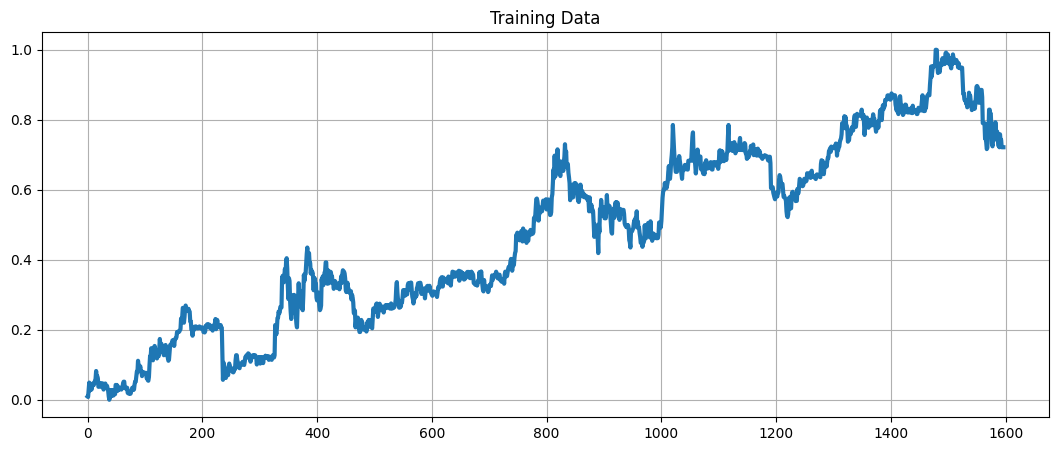

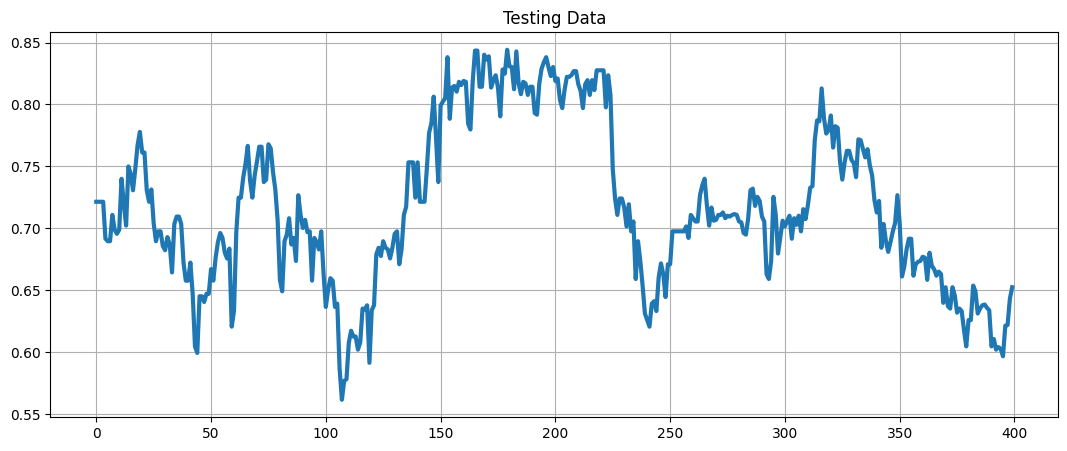

In [428]:
# Define a data plotting function
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')

In [429]:
# Reshape the 1D arrays to 2D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
X_train.shape, X_test.shape

((1597, 1), (400, 1))

# Creating Model

In [430]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[1]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mae") #model.compile(optimizer=SGD(learning_rate=0.1 0.001 0.0001))
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 150)            91200     
                                                                 
 dropout_12 (Dropout)        (None, 1, 150)            0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 150)            180600    
                                                                 
 dropout_13 (Dropout)        (None, 1, 150)            0         
                                                                 
 lstm_20 (LSTM)              (None, 150)               180600    
                                                                 
 dense_6 (Dense)             (None, 1)                 151 

In [431]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
40/40 [==============================] - 10s 100ms/step - loss: 0.2094 - val_loss: 0.2902
Epoch 2/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0654 - val_loss: 0.0948
Epoch 3/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0286 - val_loss: 0.0282
Epoch 4/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0264 - val_loss: 0.0202
Epoch 5/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0253 - val_loss: 0.0139
Epoch 6/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0235 - val_loss: 0.0127
Epoch 7/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0226 - val_loss: 0.0169
Epoch 8/20
40/40 [==============================] - 1s 19ms/step - loss: 0.0230 - val_loss: 0.0289
Epoch 9/20
40/40 [==============================] - 1s 19ms/step - loss: 0.0220 - val_loss: 0.0360
Epoch 10/20
40/40 [==============================] - 1s 18ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 1

# Make Prediction

In [432]:
predicted = model.predict(X)

63/63 [==============================] - 2s 6ms/step


In [433]:
predicted

array([[0.02861999],
       [0.02733463],
       [0.04791331],
       ...,
       [0.62121946],
       [0.6411724 ],
       [0.64987785]], dtype=float32)

In [434]:
# Append the predicted values to the list
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [435]:
test_predicted

[0.028619986,
 0.027334627,
 0.04791331,
 0.067229,
 0.04533952,
 0.055637017,
 0.060788088,
 0.04791331,
 0.058212362,
 0.064652376,
 0.059500188,
 0.060788088,
 0.06594064,
 0.072383314,
 0.07753901,
 0.09946486,
 0.08140666,
 0.08527501,
 0.07882814,
 0.055637017,
 0.055637017,
 0.060788088,
 0.06594064,
 0.06336419,
 0.055637017,
 0.064652376,
 0.060788088,
 0.064652376,
 0.04791331,
 0.06207609,
 0.063364185,
 0.06465236,
 0.05306207,
 0.056924656,
 0.058212362,
 0.050487492,
 0.04405277,
 0.028619986,
 0.019624798,
 0.02990546,
 0.028619986,
 0.04662635,
 0.031191047,
 0.04662635,
 0.040193155,
 0.031191047,
 0.035048455,
 0.04533952,
 0.035048455,
 0.060788088,
 0.058212362,
 0.060788088,
 0.04405277,
 0.056924656,
 0.04662635,
 0.04791331,
 0.05177472,
 0.050487492,
 0.05306207,
 0.04791331,
 0.05306207,
 0.0543495,
 0.06594063,
 0.06980598,
 0.06980598,
 0.05177472,
 0.05306207,
 0.05177472,
 0.049200337,
 0.05306207,
 0.038906824,
 0.040193155,
 0.03633447,
 0.03762059,
 0.04

In [436]:
df_predicted = stock_price_df[1:][['Date']]
df_predicted

,Date
1,2012-01-03
2,2012-01-04
3,2012-01-05
4,2012-01-06
5,2012-01-09
...,...
1993,2019-12-20
1994,2019-12-23
1995,2019-12-26
1996,2019-12-27


In [437]:
df_predicted['LSTM Prediction'] = test_predicted

In [438]:
df_predicted

,Date,LSTM Prediction
1,2012-01-03,0.028620
2,2012-01-04,0.027335
3,2012-01-05,0.047913
4,2012-01-06,0.067229
5,2012-01-09,0.045340
...,...,...
1993,2019-12-20,0.597431
1994,2019-12-23,0.620595
1995,2019-12-26,0.621219
1996,2019-12-27,0.641172


# Plot the data

In [439]:
close = []
for i in training_set_scaled:
  close.append(i[0])

In [440]:
df_predicted['Close'] = close[1:]
df_predicted

,Date,LSTM Prediction,Close
1,2012-01-03,0.028620,0.007958
2,2012-01-04,0.027335,0.029178
3,2012-01-05,0.047913,0.049072
4,2012-01-06,0.067229,0.026525
5,2012-01-09,0.045340,0.037135
...,...,...,...
1993,2019-12-20,0.597431,0.621353
1994,2019-12-23,0.620595,0.622016
1995,2019-12-26,0.621219,0.643236
1996,2019-12-27,0.641172,0.652520


# Plot the data

In [441]:
# Plot the data
interactive_plot(df_predicted, "Original Vs Prediction")

# Calculate MAPE

In [442]:
# Calculate MAPE
mask = df_predicted['Close'] != 0
mape = np.mean(np.abs((df_predicted['Close'][mask] - df_predicted['LSTM Prediction'][mask]) / df_predicted['Close'][mask])) * 100
print("MAPE:", mape)

MAPE: 7.211323095349452


In [443]:
# Calculate the 50-day moving average
df_predicted['50MA'] = df_predicted['Close'].rolling(window=50).mean()

# Calculate the 200-day moving average
df_predicted['200MA'] = df_predicted['Close'].rolling(window=200).mean()

# Plot the close price, 50-day moving average, and 200-day moving average
fig = px.line(df_predicted, x='Date', y=['Close', '50MA', '200MA', 'LSTM Prediction'], title='Close Price with Moving Averages and LSTM')
fig.show()

In [444]:
df_predicted

,Date,LSTM Prediction,Close,50MA,200MA
1,2012-01-03,0.028620,0.007958,NaN,NaN
2,2012-01-04,0.027335,0.029178,NaN,NaN
3,2012-01-05,0.047913,0.049072,NaN,NaN
4,2012-01-06,0.067229,0.026525,NaN,NaN
5,2012-01-09,0.045340,0.037135,NaN,NaN
...,...,...,...,...,...
1993,2019-12-20,0.597431,0.621353,0.650517,0.712384
1994,2019-12-23,0.620595,0.622016,0.649005,0.711343
1995,2019-12-26,0.621219,0.643236,0.647785,0.710444
1996,2019-12-27,0.641172,0.652520,0.646300,0.709556


In [445]:
# Calculate MAPE for 50-day Moving Average
df_predicted['50MA_MAPE'] = np.abs((df_predicted['Close'] - df_predicted['50MA']) / df_predicted['Close']) * 100
df_predicted['50MA_MAPE'] = df_predicted['50MA_MAPE'].replace(np.inf, np.nan)

# Calculate MAPE for 200-day Moving Average
df_predicted['200MA_MAPE'] = np.abs((df_predicted['Close'] - df_predicted['200MA']) / df_predicted['Close']) * 100
df_predicted['200MA_MAPE'] = df_predicted['200MA_MAPE'].replace(np.inf, np.nan)

# Calculate MAPE for LSTM predictions
df_predicted['LSTM_MAPE'] = np.abs((df_predicted['Close'] - df_predicted['LSTM Prediction']) / df_predicted['Close']) * 100
df_predicted['LSTM_MAPE'] = df_predicted['LSTM_MAPE'].replace(np.inf, np.nan)

# Print MAPE values
print("50-day MAPE:", df_predicted['50MA_MAPE'].mean())
print("200-day MAPE:", df_predicted['200MA_MAPE'].mean())
print("LSTM MAPE:", df_predicted['LSTM_MAPE'].mean())

50-day MAPE: 10.865727747519339
200-day MAPE: 16.73140143955079
LSTM MAPE: 7.211323095349452
